# Predicting Stock Prices using Regression
* We'll use three different algorithms to predict stock prices
* The DIJ API used to be free, but unfortunately, at the moment we can only get
the dataset from kaggle, which includes 2767 closing records from January 4th
2009 to December 31st 2019: https://www.kaggle.com/datasets/mnassrib/dow-jones-industrial-average
* Our training data will therefore be from 2009 until 2008 and our test data
will be from 2019

## Step 1: Loading the dataset (and splitting it into training and testing)
* We already declared functions to read and prepare the dataset on the file: 07_preparing_dji_data.ipynb
* We'll use nbimporter in order to get the functions and prepare the data

In [1]:
# In order to prepare the dataset and transform the features, we need to
# perform some operations on the initial dataset (formatting)
import nbimporter
from preparing_dji_data import generate_features
import pandas as pd
import numpy as np

# Storing the data in a dataframe and renaming Price and Vol to Close and Volume
df_raw = pd.read_csv("./dataset/doj_historical.csv", index_col="Date", parse_dates=True)

df_raw.rename(columns = {"Price" : "Close", "Vol.": "Volume" }, inplace = True)
# Evaluating the columns and the content of the dataframe
df_raw.head(5)

# We have six original columns and we'll transform them to get more dimensions

# We need to drop the Change % column
df_raw.drop("Change %", axis = 1, inplace = True)

# Find rows with '-' in any of the columns
filtered_df = df_raw[df_raw.apply(lambda row: row.str.contains('-')).any
(axis=1)]
print("\nRows with '-' symbol:")
print(filtered_df)

# We'll delete the M for all values and multiply for 1000,
# All other values that contain "-", we'll replace them with nan
df_raw['Volume'] = df_raw['Volume'].apply(lambda x: 1000 * float(x.replace("M",
                                                                        ""))
if x != "-" else float("nan"))

df_raw['Volume']

from sklearn.impute import SimpleImputer

# Use the SimpleImputer to convert all missing values from nan to the mean of
# all other rows
volume_transformed = SimpleImputer(missing_values = np.nan, strategy = "mean")
volume_transformed.fit(df_raw['Volume'].values.reshape(-1, 1))
volume_transformed.transform(df_raw['Volume'].values.reshape(-1, 1))

df_raw['Volume']

# Making sure that all values are of type float since there are some
# characters (commas, suffixes) that will stop us from using the functions
def remove_commas(value):
    """
    This function converts strings in our rows into floats. It also removes
    commas and the M suffix in the column for volume.
    @param value: str, The value in the current row
    @return: float, a clean version of the original data
    """
    return float(value.replace(",", ""))

# Applying the custom function to all elements in the dataframe
df_raw.iloc[:,:-1] = df_raw.iloc[:,:-1].applymap(remove_commas)





Rows with '-' symbol:
                Close       Open       High        Low Volume
Date                                                         
2010-05-13  10,782.95  10,896.61  10,952.84  10,752.72      -
2010-05-12  10,896.91  10,742.15  10,941.88  10,725.81      -
2010-05-11  10,748.26  10,780.00  10,888.30  10,653.71      -
2010-05-10  10,785.14  10,386.18  10,880.14  10,386.18      -
2010-05-07  10,380.43  10,519.42  10,622.27  10,221.50      -
...               ...        ...        ...        ...    ...
2009-01-09   8,599.18   8,738.80   8,800.45   8,541.75      -
2009-01-08   8,742.46   8,769.94   8,807.14   8,593.52      -
2009-01-07   8,769.70   8,996.94   8,996.94   8,690.45      -
2009-01-06   9,015.10   8,954.57   9,175.19   8,868.07      -
2009-01-05   8,952.89   9,027.13   9,093.47   8,841.70      -

[342 rows x 5 columns]


In [2]:
# Creating a new, enhanced dataset:
data = generate_features(df_raw)
# The dimensions of our new dataset: 38, 2171
print(len(data.columns), len(data.values))

# Sorting first in reverse order:
data.sort_index(inplace=True, ascending=False)
data_asc = data.sort_index(inplace=False, ascending=True)  # New line

# Taking a look at what the data with the new features looks like
print(data.round(decimals=3).head(5))

38 2171
                open    open_1   close_1    high_1     low_1  volume_1   
Date                                                                     
2018-12-27  22629.06  23213.61   23062.4  23381.88  22981.33  336510.0  \
2018-12-26  21857.73  22629.06  23138.82  23138.89  22267.42  407940.0   
2018-12-24  22317.28  21857.73  22878.45  22878.92  21712.53  433080.0   
2018-12-21  22871.74  22317.28   21792.2  22339.87   21792.2  308420.0   
2018-12-20  23224.12  22871.74  22445.37  23254.59  22396.34  900510.0   

            avg_price_5  avg_price_30  avg_price_365  ratio_avg_price_5_30   
Date                                                                         
2018-12-27    23171.096     23985.192      26337.481                 0.966  \
2018-12-26    23112.228     23916.566      26315.630                 0.966   
2018-12-24    23150.674     23838.006      26292.841                 0.971   
2018-12-21    22839.866     23697.768      26266.161                 0.964   
2018-

In [3]:
# Defining the dates for our training and testing dataset (chronologically)
start_train = '2010-05-13'
end_train = '2017-12-31'
start_test = '2018-01-01'
end_test = '2018-12-27'

# Splitting our data
data_train = data_asc.loc[start_train:end_train]  # Updated
data_test = data_asc.loc[start_test:end_test]  # Updated

# We have 1922 samples for training and 249 for testing.
train_sample_num = data_train.shape[0]
test_sample_num = data_test.shape[0]
print(f"Training: {train_sample_num}, Testing: {test_sample_num}")
print(f"The ratio between training and testing is: {train_sample_num  /(train_sample_num + test_sample_num):.2f}% ")

# We have a 90/10 split.


Training: 1922, Testing: 249
The ratio between training and testing is: 0.89% 


In [4]:
# Dropping the target from the training dataset
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values

X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values

## Step 2: Using the Linear Regression algorithm with Stochastic Gradient Descent
* SGD is sensitive to data with features at very different scales.
* We need to normalize the features into the same or a comparable scale, so
we'll remove the mean and we'll rescale to unit variance using StandardScaler
* We'll use GridSearchCV to find the optimal hyperparameters (l2 regularization,
100_000 iterations and fine tune *alpha* and *learning rate*).

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Rescale both sets with scaler, taught by the training set
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)


In [6]:
# Now we'll look for the SGD-based linear regression model with the optimal
# set of parameters using GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor

param_grid = {
    "alpha" : [1e-4, 1e-3, 1e-2],
    "eta0" : [0.001, 0.01, 0.1],
}

linear_model =  SGDRegressor(penalty = 'l2', max_iter = 100_000, random_state =
42)

# Finding the best model with cross-validation (5) and R² as the eval metric
grid_search = GridSearchCV(linear_model, param_grid, cv=5, scoring = "r2")

grid_search.fit(X_scaled_train, y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(max_iter=100000, random_state=42),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'eta0': [0.001, 0.01, 0.1]},
             scoring='r2')

In [7]:
# Select the best linear regression model and make predictions of the testing samples:
print(f"Best parameters found: {grid_search.best_params_}")

linear_best_model = grid_search.best_estimator_

predictions_lr = linear_best_model.predict(X_scaled_test)

Best parameters found: {'alpha': 0.001, 'eta0': 0.1}


In [8]:
# Measuring performance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print(f'MSE: {mean_squared_error(y_test, predictions_lr):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions_lr):.3f}')
print(f'R^2: {r2_score(y_test, predictions_lr):.3f}')



MSE: 13051.759
MAE: 87.904
R^2: 0.980


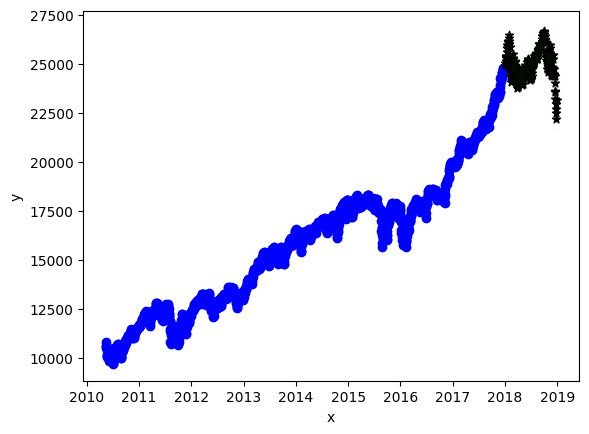

In [9]:
# Visualizing our predictions
# Checking the model's performance on new samples
import matplotlib.pyplot as plt


# Plotting both the train set, the new predicted values and the true values
plt.scatter(data_train.index, y_train, marker = "o", c = "b")
plt.scatter(data_test.index, predictions_lr, marker = "*", c = "k")
plt.scatter(data_test.index, y_test, marker = "^", c = "g", alpha = 0.01)


plt.xlabel("x")
plt.ylabel("y")

plt.show()

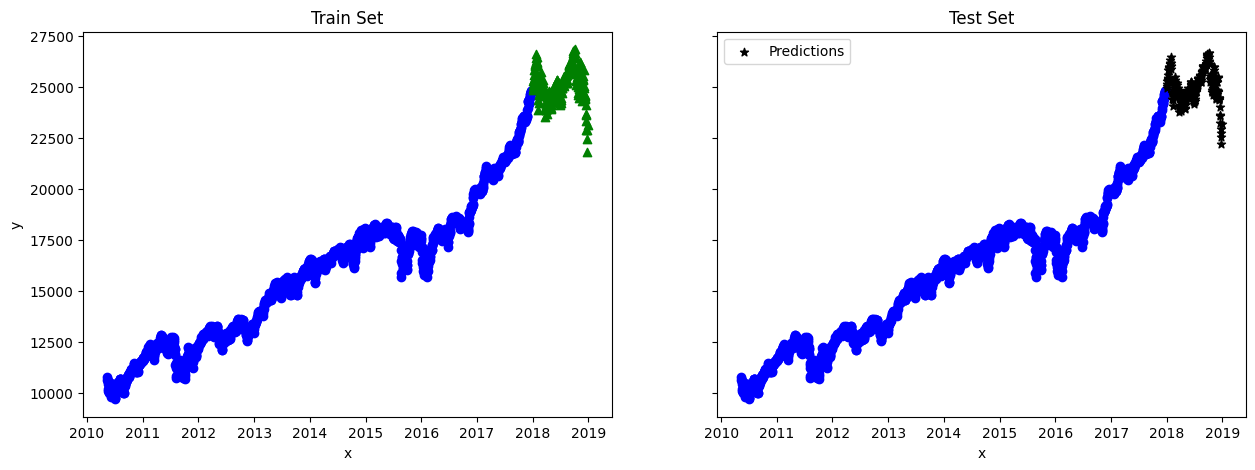

In [10]:
# Side to side comparison:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plotting the train set on the first plot (ax1)
ax1.scatter(data_train.index, y_train, marker="o", c="b")
ax1.scatter(data_test.index, y_test, marker="^", c="g", label='True Values')

ax1.set_title('Train Set')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Plotting the predicted values and true values on the second plot (ax2)
ax2.scatter(data_train.index, y_train, marker="o", c="b")
ax2.scatter(data_test.index, predictions_lr, marker="*", c="k", label='Predictions')
ax2.set_title('Test Set')
ax2.set_xlabel('x')

# Adding a legend to the second plot
ax2.legend()

plt.show()


## Step 3: Predicting using a random forest model
* We'll experiment with 500 trees to ensemble and tune the depth of the tree,
 max_depth, the min_samples_split and the number of features used for each tree

In [11]:
# Building our RF classifier
from sklearn.ensemble import RandomForestRegressor
# Defining parameters for the tree
param_grid = {
    'max_depth' : [15, 45],
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [3, 5, 10]
}

random_forest = RandomForestRegressor(n_estimators = 1000, n_jobs = -1,
                                      max_features = 'auto', random_state = 42)

grid_search = GridSearchCV(random_forest, param_grid, cv = 5, scoring='r2',
                           n_jobs = -1)
grid_search.fit(X_train, y_train)


C:\Users\52556\Documents_outside_ODB\Python_Excercises\Machine_Learning\Machine_Learning_by_Example\tensorflow_env\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='auto',
                                             n_estimators=1000, n_jobs=-1,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [15, 45], 'min_samples_leaf': [3, 5, 10],
                         'min_samples_split': [2, 5]},
             scoring='r2')

In [12]:
# Predicting and evaluating
print(grid_search.best_params_)

rf_best = grid_search.best_estimator_

predictions_rf = rf_best.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, predictions_rf):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions_rf):.3f}')
print(f'R^2: {r2_score(y_test, predictions_rf):.3f}')


{'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 2}
MSE: 1661164.050
MAE: 1053.722
R^2: -1.509


## SVR With a linear and RBF Kernel
* We'll fine tune the C, E and kernel coefficient of RBF
* We need to use the scaled features

In [13]:
from sklearn.svm import SVR
# Define params
param_grid = [
	{'kernel' : ['linear'], 'C': [100, 300, 500],
     'epsilon': [3e-5, 1e-4]},
	{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
     'C': [10, 100, 1000], 'epsilon': [3e-5, 1e-4]}
]

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')
grid_search.fit(X_scaled_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [100, 300, 500], 'epsilon': [3e-05, 0.0001],
                          'kernel': ['linear']},
                         {'C': [10, 100, 1000], 'epsilon': [3e-05, 0.0001],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
             scoring='r2')

In [14]:
# Evaluating and predicting:

print(grid_search.best_params_)
svr_best = grid_search.best_estimator_
predictions_svr = svr_best.predict(X_scaled_test)
print(f'MSE: {mean_squared_error(y_test, predictions_svr):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions_svr):.3f}')
print(f'R^2: {r2_score(y_test, predictions_svr):.3f}')


{'C': 500, 'epsilon': 0.0001, 'kernel': 'linear'}
MSE: 7906.168
MAE: 65.321
R^2: 0.988


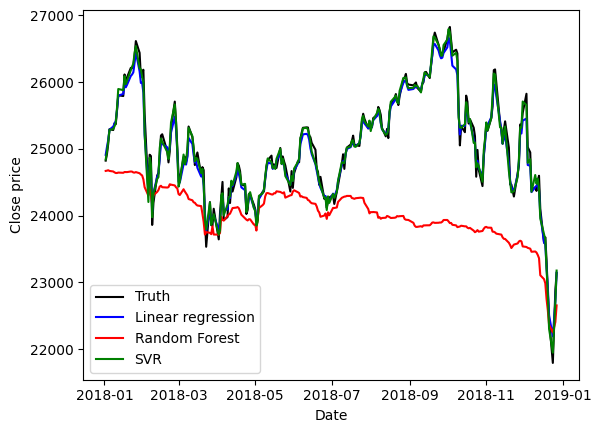

In [15]:
# A final visualization of the model's performance together
import matplotlib.pyplot as plt


plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions_lr, c='b')
plt.plot(data_test.index, predictions_rf, c='r')
plt.plot(data_test.index, predictions_svr, c='g')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truth', 'Linear regression', 'Random Forest', 'SVR'])
plt.show()

# Averaging the SVR and Linear SGD performance
* We'll use the best models, average their predictions and evaluate the
results (with the truth ones).


In [16]:
# Averaging the model's predictions
averaged_predictions = (predictions_lr + predictions_svr)/ 2

print(f'MSE: {mean_squared_error(y_test, averaged_predictions):.3f}')
print(f'MAE: {mean_absolute_error(y_test, averaged_predictions):.3f}')
print(f'R^2: {r2_score(y_test, averaged_predictions):.3f}')

MSE: 8907.774
MAE: 71.132
R^2: 0.987
